# サマリー

- albumentationsはDA用のライブラリ
- torchvision.transformsと同じインターフェイスを持つ
- torchvision.transformsよりも種類が豊富
- Composeにbounding boxも渡せるため、物体検出に便利　

# コード

In [1]:
import torchvision

from PIL import Image, ImageDraw
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline


## データセットの準備

In [2]:
# torchvision のチュートリアルから引用
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# datasetのURL https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

import numpy as np
import torch
from PIL import Image
import os


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
#         target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
dataset = PennFudanDataset(root='../PennFudanPed', transforms=None)

In [4]:
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FC015B625C0>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [5]:
def show_numpy2image(image: np.ndarray):
    plt.figure(figsize=(16, 8))
    image= Image.fromarray(image, 'RGB')
    plt.imshow(image)
    plt.axis('off')

In [6]:
img, target = dataset.__getitem__(0)

In [7]:
# PIL imageはDAできないのでcv2/numpyを使うことになる
image = np.array(img)
boxes = target['boxes']

In [8]:
#  imageというkeyを格納した辞書になる
A.HorizontalFlip(p=1)(image=image)

{'image': array([[[148, 101,  83],
         [146,  99,  81],
         [143,  96,  78],
         ...,
         [212, 201, 183],
         [210, 199, 181],
         [211, 200, 182]],
 
        [[128,  81,  63],
         [128,  81,  63],
         [126,  79,  61],
         ...,
         [170, 159, 141],
         [173, 162, 144],
         [179, 168, 150]],
 
        [[130,  83,  65],
         [131,  84,  66],
         [130,  83,  65],
         ...,
         [188, 177, 159],
         [194, 183, 165],
         [204, 193, 175]],
 
        ...,
 
        [[185, 185, 185],
         [184, 184, 184],
         [183, 183, 183],
         ...,
         [211, 205, 205],
         [217, 211, 211],
         [226, 220, 220]],
 
        [[186, 186, 186],
         [187, 187, 187],
         [187, 187, 187],
         ...,
         [210, 204, 204],
         [219, 213, 213],
         [231, 225, 225]],
 
        [[187, 187, 187],
         [190, 190, 190],
         [190, 190, 190],
         ...,
         [215, 209,

In [9]:
A.HorizontalFlip(p=1)(image=image)['image'].shape

(536, 559, 3)

## 分類問題のDAとして使う場合

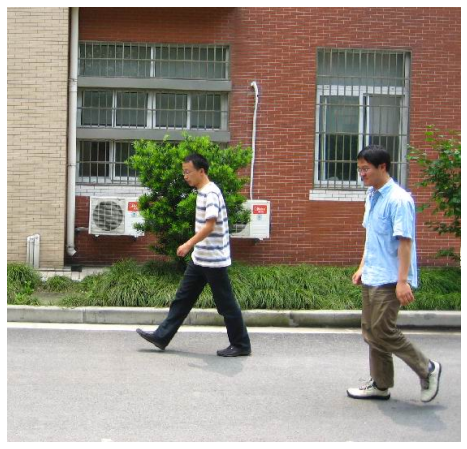

In [10]:
# 元の画像
show_numpy2image(image)

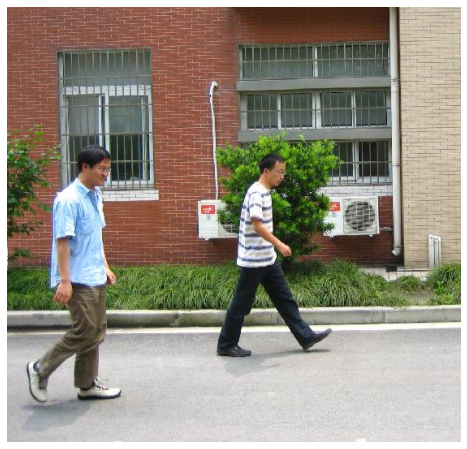

In [11]:
# Horizontal flip
transformed_img = A.HorizontalFlip(p=1)(image=image)['image']
show_numpy2image(transformed_img)

In [ ]:
# 複数のDA
transforms = A.Compose([
        A.VerticalFlip(p=1),
        A.HorizontalFlip(p=1)
    ])
transformed_img = transforms(image=image)['image']
show_numpy2image(transformed_img)

torchvision.transformsと同じように使える。   
DAの種類としてはtorchvisionよりも多いため、albumentationsのほうが良さそう。

In [ ]:
# 同様に様々なAugmentationを試す
# See https://albumentations.readthedocs.io/en/latest/api/augmentations.html

aug_lists = {
                    'Original': None,
                    'HorizontalFlip': A.HorizontalFlip(p=1),
                    'VerticalFlip': A.VerticalFlip(p=1),
                    'RandomSunFlare': A.RandomSunFlare(p=1),  # 光をランダムに当てる
                    'RandomFog': A.RandomFog(p=1),  # 霧みたいな感じ
                    'RandomBrightness': A.RandomBrightness(p=1),  # 明るさを変える
                    'RandomCrop': A.RandomCrop(p=1,height = 256, width = 256), 
                    'Rotation': A.Rotate(p=1, limit=90),  # 90度以下で回転させる
                    'RGBShift': A.RGBShift(p=1),  # 各RGB値を-20~20まで増減させる
                    'RandomSnow': A.RandomSnow(p=1),  # 雪を降らせる
                    'RandomContrast': A.RandomContrast(limit = 0.5,p = 1),
                    'HueSaturation': A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)  # Hue: 影、　saturation: はっきりしている度合い
}

nrows = 3
ncols = 4
fig, axes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
fig.suptitle('Various Augmentations By Albumentations')
for i, (key_, aug) in enumerate(aug_lists.items()):
    if aug is None:
        transformed_img = image
    else:
        transformed_img = aug(image=image)['image']
    axes[i // ncols][i % ncols].imshow(transformed_img)
    axes[i // ncols][i % ncols].set_title(key_, fontsize=15)

色々簡単にできる

## 物体検出用のDA

In [ ]:
def show_image_with_bbox(image: np.ndarray, boxes: np.ndarray):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

In [ ]:
show_image_with_bbox(image, boxes)

bounding boxごとうまくずらしてくれるのがalbumentationsの素敵なところ。   
torchvision.transformsではこれができないため物体検出で使うにはかなりコードを書かないといけない。

In [ ]:
# composeするときにbbox_paramパラメータを渡してあげる
# formatは、(x_min, x_max, y_min, y_max)ならpascal_voc, (x_min, y_min, w, h)ならcoco
# label_fieldsはbouding box内にある物体のラベル情報

hol_flip = A.Compose([
        A.HorizontalFlip(p=1),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# 今回は人クラスのみなため、すべてlabelは1にする
hol_flip_annotations = hol_flip(image=image, bboxes=boxes, labels=np.ones((boxes.shape[0])))

In [ ]:
show_image_with_bbox(hol_flip_annotations['image'], hol_flip_annotations['bboxes'])

bounding boxごとAlbumentasionにわたすことで、うまく処理してくれる

In [ ]:
# 同様に様々なAugmentationと一緒に試す
# See https://albumentations.readthedocs.io/en/latest/api/augmentations.html

aug_lists = {
                    'Original': None,
                    'HorizontalFlip': A.HorizontalFlip(p=1),
                    'VerticalFlip': A.VerticalFlip(p=1),
                    'RandomSunFlare': A.RandomSunFlare(p=1),  # 光をランダムに当てる
                    'RandomFog': A.RandomFog(p=1),  # 霧みたいな感じ
                    'RandomBrightness': A.RandomBrightness(p=1),  # 明るさを変える
                    'RandomCrop': A.RandomCrop(p=1,height = 256, width = 256), 
                    'Rotation': A.Rotate(p=1, limit=90),  # 90度以下で回転させる
                    'RGBShift': A.RGBShift(p=1),  # 各RGB値を-20~20まで増減させる
                    'RandomSnow': A.RandomSnow(p=1),  # 雪を降らせる
                    'RandomContrast': A.RandomContrast(limit = 0.5,p = 1),
                    'HueSaturation': A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)  # Hue: 影、　saturation: はっきりしている度合い
}

nrows = 3
ncols = 4
fig, axes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
fig.suptitle('Various Augmentations By Albumentations')
for i, (key_, aug) in enumerate(aug_lists.items()):
    if aug is None:
        transformed_img = image
        transformed_boxes = boxes
    else:
        transform = A.Compose([aug], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
        annotations = transform(image=image, bboxes=boxes, labels=np.ones((boxes.shape[0])))
        transformed_img = annotations['image']
        transformed_boxes = annotations['bboxes']

    axes[i // ncols][i % ncols].set_axis_off()
    axes[i // ncols][i % ncols].imshow(transformed_img)
    axes[i // ncols][i % ncols].set_title(key_, fontsize=15)
    

## まとめ

- albumentationsはDA用のライブラリ
- torchvision.transformsと同じインターフェイスを持つ
- torchvision.transformsよりも種類が豊富
- Composeにbounding boxも渡せるため、物体検出に便利　